In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import cv2

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader

In [2]:
data_path = 'potato-diseases-datasets-test'

In [3]:
classes = os.listdir(data_path)

class_images = {}

for i in classes:
    
    class_images[i] = random.sample(os.listdir(os.path.join(data_path, i)), 5)

class_images

{'Black Scurf': ['43.jpg', '36.jpg', '38.jpg', '26.jpg', '30.jpg'],
 'Blackleg': ['57.jpg', '22.jpg', '53.jpg', '32.jpg', '45.jpg'],
 'Common Scab': ['52.jpg', '49.jpg', '34.jpg', '44.jpg', '51.jpg'],
 'Dry Rot': ['33.jpg', '18.jpg', '36.jpg', '40.jpg', '7.jpg'],
 'Healthy Potatoes': ['51.jpg', '12.jpg', '72.jpg', '75.jpg', '42.jpg'],
 'Miscellaneous': ['73.jpg', '48.jpg', '50.jpg', '55.jpg', '6.jpg'],
 'Pink Rot': ['26.jpg', '48.jpg', '43.jpg', '15.jpg', '21.jpg']}

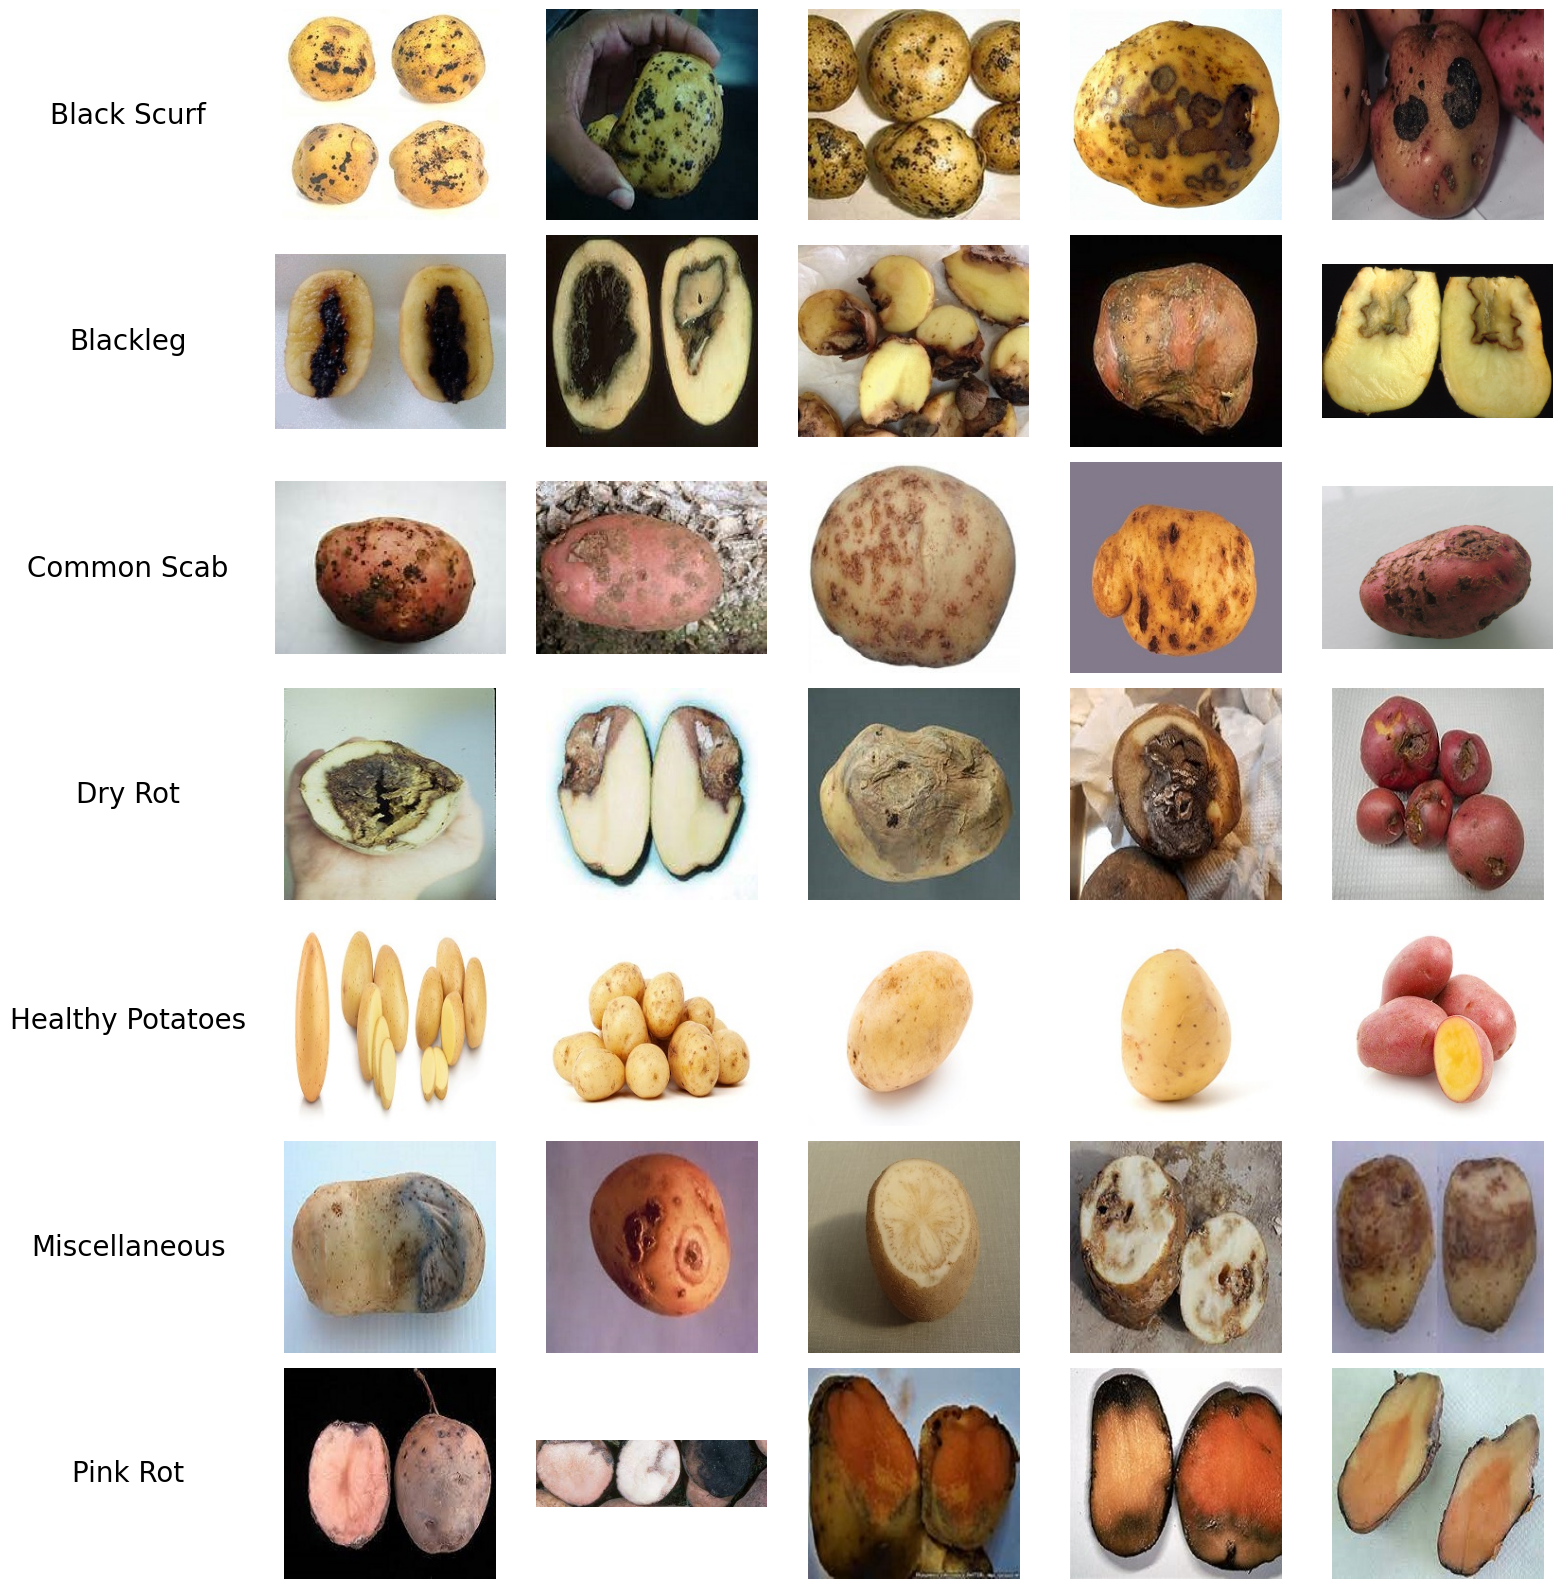

In [4]:
fig, ax = plt.subplots(7, 6, figsize=(16, 16))

# Loop through each class and its images
for i, class_name in enumerate(class_images):
    
    # Display the class name before each row
    ax[i, 0].text(0.5, 0.5, class_name, fontsize=20, ha='center', va='center', transform=ax[i, 0].transAxes)
    ax[i, 0].axis('off')
    
    for j, file in enumerate(class_images[class_name]):
        # Load and display the image
        image = cv2.imread(os.path.join(data_path, class_name, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax[i, j + 1].imshow(image)
        ax[i, j + 1].axis('off')
    
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [5]:
# Check number of images in each class

for i in os.listdir(data_path):
    
    length = len(os.listdir(os.path.join(data_path, i)))
    
    print('{} = {} Images'.format(i, length))
    print()

Black Scurf = 58 Images

Blackleg = 60 Images

Common Scab = 62 Images

Dry Rot = 60 Images

Healthy Potatoes = 80 Images

Miscellaneous = 74 Images

Pink Rot = 57 Images



In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [8]:
data_transforms = transforms.Compose([
    
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
])

In [9]:
path = 'potato-diseases-datasets'

image_datasets = datasets.ImageFolder(path, data_transforms)

train_size = int(0.8 * len(image_datasets))
test_size = len(image_datasets) - train_size

train_datasets, test_datasets = torch.utils.data.random_split(image_datasets, [train_size, test_size])

In [10]:
dataloader = {}

dataloader['train'] = DataLoader(train_datasets, batch_size = 4, shuffle= True, num_workers = 4)
dataloader['test'] = DataLoader(test_datasets, batch_size = 4, shuffle= True, num_workers = 4)

In [11]:
dataset_sizes = {}

dataset_sizes['train'] = len(train_datasets)
dataset_sizes['test'] = len(test_datasets)

In [12]:
class_names = image_datasets.classes

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            if epoch%10 == 0:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)
            
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train() 
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloader[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                if epoch%10 == 0:
                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                    print()

                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
model_ft = models.mobilenet_v2(pretrained='True')
num_ftrs = model_ft.classifier[1].in_features

model_ft.fc = nn.Linear(num_ftrs, 7)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

d:\CODE\PotatoDiseaseClassification\.conda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\CODE\PotatoDiseaseClassification\.conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:

model_save_path = "mobilenet_potato.pth"

if os.path.exists(model_save_path):
    print("Loading saved model...")
    model_ft = models.mobilenet_v2(pretrained=False)
    num_ftrs = model_ft.classifier[1].in_features
    model_ft.fc = nn.Linear(num_ftrs, 7)
    model_ft = model_ft.to(device)
    model_ft.load_state_dict(torch.load(model_save_path, map_location=device))
else:
    print("No saved model found. Training...")
    model_ft = models.mobilenet_v2(pretrained=True)
    num_ftrs = model_ft.classifier[1].in_features
    model_ft.fc = nn.Linear(num_ftrs, 7)
    model_ft = model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200)
    torch.save(model_ft.state_dict(), model_save_path)

No saved model found. Training...
Epoch 0/199
----------
train Loss: 3.6230 Acc: 0.3222

test Loss: 3.2920 Acc: 0.3297

Epoch 10/199
----------
train Loss: 0.9354 Acc: 0.6528

test Loss: 0.8860 Acc: 0.6813

Epoch 20/199
----------
train Loss: 0.9290 Acc: 0.6694

test Loss: 0.8236 Acc: 0.7253

Epoch 30/199
----------
train Loss: 0.7562 Acc: 0.7167

test Loss: 0.8320 Acc: 0.7253

Epoch 40/199
----------
train Loss: 0.8434 Acc: 0.6972

test Loss: 0.7772 Acc: 0.7143

Epoch 50/199
----------
train Loss: 0.7851 Acc: 0.7444

test Loss: 0.8750 Acc: 0.6813

Epoch 60/199
----------
train Loss: 0.8730 Acc: 0.6806

test Loss: 0.8377 Acc: 0.7033

Epoch 70/199
----------
train Loss: 0.8186 Acc: 0.7000

test Loss: 0.7868 Acc: 0.7363

Epoch 80/199
----------
train Loss: 0.8724 Acc: 0.6833

test Loss: 0.8493 Acc: 0.7253

Epoch 90/199
----------
train Loss: 0.7848 Acc: 0.7361

test Loss: 0.8308 Acc: 0.7253

Epoch 100/199
----------
train Loss: 0.8259 Acc: 0.7167

test Loss: 0.8299 Acc: 0.6703

Epoch 110

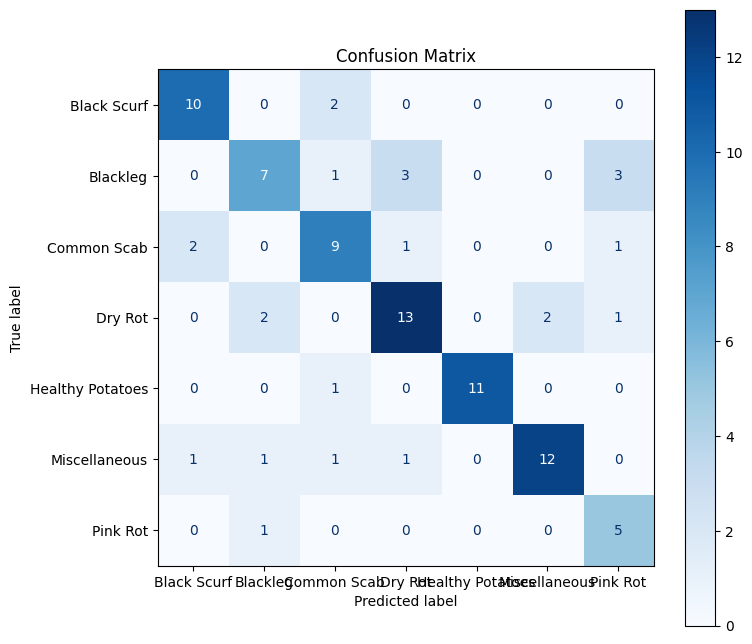

                  precision    recall  f1-score   support

     Black Scurf       0.77      0.83      0.80        12
        Blackleg       0.64      0.50      0.56        14
     Common Scab       0.64      0.69      0.67        13
         Dry Rot       0.72      0.72      0.72        18
Healthy Potatoes       1.00      0.92      0.96        12
   Miscellaneous       0.86      0.75      0.80        16
        Pink Rot       0.50      0.83      0.62         6

        accuracy                           0.74        91
       macro avg       0.73      0.75      0.73        91
    weighted avg       0.75      0.74      0.74        91



In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Gather all predictions and true labels from the test set
all_preds = []
all_labels = []

model_ft.eval()
with torch.no_grad():
    for inputs, labels in dataloader['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

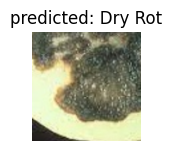

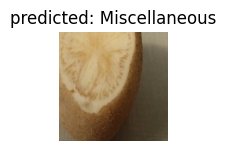

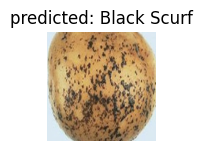

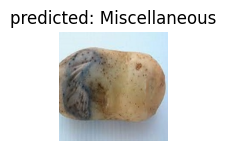

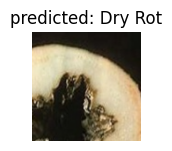

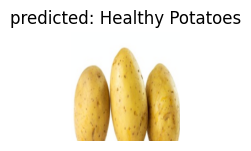

In [18]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [1]:
# %% [markdown]
# ---------------------------------------------------------------
#  Data-augmentation pipeline: RandAugment → Crop → Flip → MixUp / CutMix
#                           → Brightness / Contrast / ColorJitter → Normalize
# ---------------------------------------------------------------

# %% [code]
import os
import logging
import tensorflow as tf

# Optional: install KerasCV once, then comment this line out
# !pip install -q --upgrade keras-cv tensorflow-addons

import keras            # RandAugment, MixUp, CutMix, ColorJitter live here
from keras import layers

# ------------ configuration --------------------------------------------------
INPUT_DIR  = r"potato-diseases-datasets"          # one sub-folder per class
OUTPUT_DIR = r"potato-diseases-datasets-augmented"      # optional, leave None to skip save

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH  = 224
AUTOTUNE   = tf.data.AUTOTUNE

# ImageNet stats, feel free to change if you use a different backbone
MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
STD  = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

# Log setup
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.StreamHandler()]
)

# ------------ helper layers ---------------------------------------------------
rand_aug   = keras.layers.RandAugment(
    value_range=(0, 255),  # work with uint8 before we rescale
    magnitude=0.3,         # 0-1, tune to taste
    augmentations_per_image=2
)

mixup      = keras.layers.MixUp(alpha=0.2)
cutmix     = keras.layers.CutMix(alpha=1.0)
colorjit   = keras.layers.ColorJitter(
    value_range=(0, 1),    # after rescaling below
    brightness_factor=0.2,
    contrast_factor=0.2,
    saturation_factor=0.2,
    hue_factor=0.08
)

# ------------ dataset loader --------------------------------------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    INPUT_DIR,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),   # initial load, we will crop again
    shuffle=True
).prefetch(AUTOTUNE)

num_classes = train_ds.element_spec[1].shape[-1]
logging.info(f"Found {num_classes} classes in {INPUT_DIR}")

# ------------ augmentation function ------------------------------------------
def augment(images, labels, training=True):
    """Pipeline matching the requested order."""
    # RandAugment expects 0-255 uint8
    images = tf.cast(images, tf.uint8)
    images = rand_aug(images)

    # Crop and flip
    images = tf.image.random_crop(
        images, size=[tf.shape(images)[0], IMG_HEIGHT, IMG_WIDTH, 3]
    )
    images = tf.image.random_flip_left_right(images)

    # Convert to float32 0-1 before color jitter and normalization
    images = tf.cast(images, tf.float32) / 255.0

    # Randomly choose MixUp or CutMix per batch
    do_mix = tf.random.uniform(shape=(), minval=0, maxval=1) < 0.5
    if training:
        batch = {"images": images, "labels": labels}
        batch = tf.cond(
            do_mix,
            lambda: mixup(batch),
            lambda: cutmix(batch)
        )
        images, labels = batch["images"], batch["labels"]

    # Color jitter (brightness, contrast, saturation, hue)
    images = colorjit(images)

    # Normalize to zero mean, unit variance
    images = (images - MEAN) / STD

    return images, labels

# ------------ tf.data mapping with progress logging --------------------------
@tf.function
def map_fn(images, labels):
    return augment(images, labels, training=True)

def save_batch_to_disk(imgs, lbls, step):
    """Optional: write augmented outputs as PNG for sanity-checking."""
    if OUTPUT_DIR is None:
        return
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    for i, img in enumerate(imgs.numpy()):
        out_path = os.path.join(OUTPUT_DIR, f"aug_{step:05d}_{i:02d}.png")
        tf.keras.preprocessing.image.save_img(out_path, img)
    logging.info(f"Saved batch {step} -> {OUTPUT_DIR}")

aug_ds = train_ds.map(map_fn, num_parallel_calls=AUTOTUNE)

# ------------ iterate once to trigger the pipeline ---------------------------
for step, (img_batch, lbl_batch) in enumerate(aug_ds):
    if step % 20 == 0:
        logging.info(f"Processed {step * BATCH_SIZE} images")
    save_batch_to_disk(img_batch, lbl_batch, step)
    # Break if you only want a quick smoke-test
    if step == 5:            # comment to run full epoch
        break


AttributeError: module 'keras.layers' has no attribute 'RandAugment'